In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import geoplot as gplt
from shapely.geometry import Point

In [3]:
df = pd.read_csv("fatal-police-shootings-data.csv")

In [4]:
df.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,-123.122,47.247,True
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,-122.892,45.487,True
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,-97.281,37.695,True
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False,-122.422,37.763,True
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False,-104.692,40.384,True


In [5]:
# first name and last name
df['first_name'] = df['name'].apply(lambda x: x.split()[0] if isinstance(x, str) else None)
df['last_name'] = df['name'].apply(lambda x: x.split()[-1] if isinstance(x, str) else None)

In [6]:
# add month and year
df['date'] = df['date'].apply(lambda x: pd.to_datetime(x))
df['month'] = df['date'].apply(lambda x: x.month)
df['year'] = df['date'].apply(lambda x: x.year)

In [7]:
df.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,...,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact,first_name,last_name,month,year
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,...,attack,Not fleeing,False,-123.122,47.247,True,Tim,Elliot,1,2015
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,...,attack,Not fleeing,False,-122.892,45.487,True,Lewis,Lembke,1,2015
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,...,other,Not fleeing,False,-97.281,37.695,True,John,Quintero,1,2015
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,...,attack,Not fleeing,False,-122.422,37.763,True,Matthew,Hoffman,1,2015
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,...,attack,Not fleeing,False,-104.692,40.384,True,Michael,Rodriguez,1,2015


C:\Users\fongc\AppData\Local\Temp\ipykernel_13624\3982337362.py:64: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


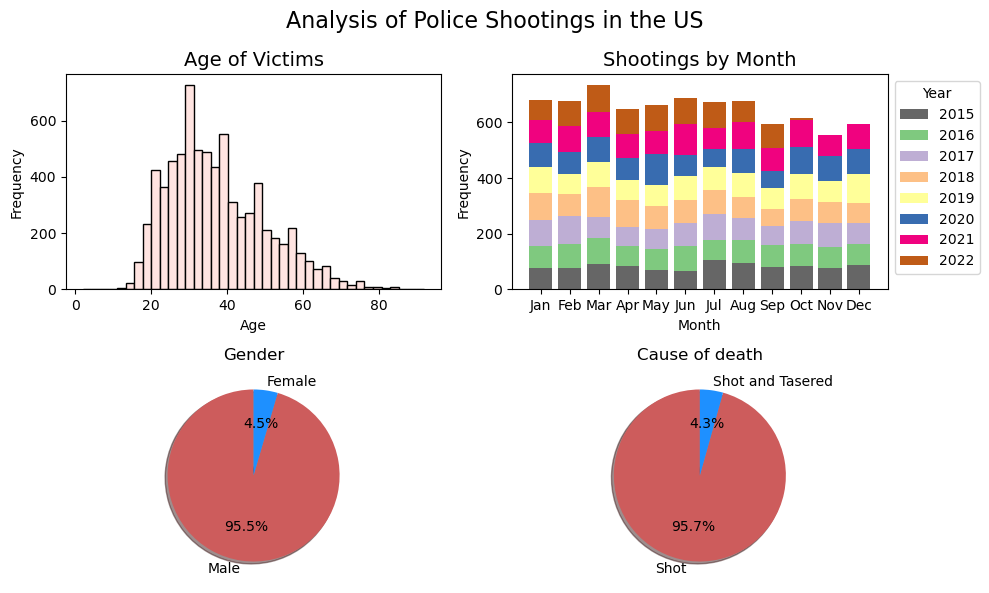

In [8]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 6))
fig.suptitle("Analysis of Police Shootings in the US", fontsize = 16)

# histogram plot
ax1.hist(
    x = df['age'],
    bins = 40,
    color = 'mistyrose',
    ec = 'black'
)
ax1.set_title("Age of Victims", fontsize = 14)
ax1.set_xlabel("Age")
ax1.set_ylabel("Frequency")

# stacked bar plot of dates
height_previous = np.zeros(12)
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for year in sorted(df['year'].unique()):
    height_year = df[df['year'] == year]['month'].value_counts().sort_index().reindex(range(1, 13), fill_value=0)

    # plot bar chart
    ax2.bar(
        x = months,
        height = height_year,
        label = year,
        bottom = height_previous,
        color = plt.get_cmap("Accent")(year % 8)
    )
    height_previous += height_year
ax2.set_title("Shootings by Month", fontsize = 14)
ax2.set_xlabel("Month")
ax2.set_ylabel("Frequency")
ax2.legend(
    title = "Year",
    loc = 'upper left',
    bbox_to_anchor = (1, 1)
)

# line graph of shootings by month
gender = df['gender'].value_counts()
ax3.pie(
    x = gender,
    labels = [ "Male", "Female" ],
    autopct = "%1.1f%%",
    shadow = True,
    startangle = 90,
    colors = [ "indianred", "dodgerblue" ]
)
ax3.set_title("Gender")

# pie chart of manner of death
manner_of_death = df['manner_of_death'].value_counts()
ax4.pie(
    x = manner_of_death,
    labels = [ "Shot", "Shot and Tasered" ],
    autopct = "%1.1f%%",
    shadow = True,
    startangle = 90,
    colors = [ "indianred", "dodgerblue" ]
)
ax4.set_title("Cause of death")

fig.tight_layout()
fig.show()

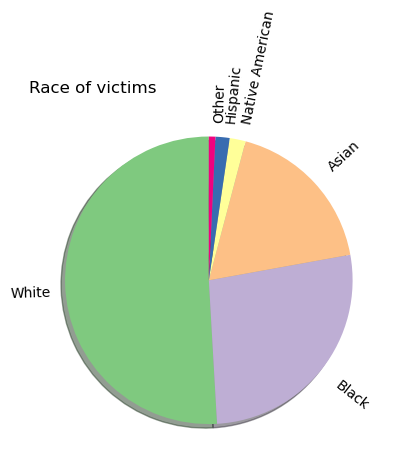

In [9]:
# plot race of victims
cmap = plt.get_cmap("Accent")
plt.pie(
    x = df['race'].value_counts(),
    labels = [ "White", "Black", "Asian", "Native American", "Hispanic", "Other" ],
    labeldistance = 1.1,
    rotatelabels = True,
    shadow = True,
    startangle = 90,
    colors = [ cmap(i % 8) for i in range(6) ]
)
plt.title("Race of victims", loc = 'left')
plt.tight_layout()

In [55]:
incidents = df.apply(lambda x: Point(x['longitude'], x['latitude']), axis = 'columns')
df_geo = gpd.GeoDataFrame(df[(df.longitude.notna()) & (df.latitude.notna()) & (df.state != "HI") & (df.state != "AK") & (df.state != "PR")], geometry = incidents)
df_geo.head()

c:\Users\fongc\anaconda3\envs\ml\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


,id,name,date,manner_of_death,armed,age,gender,race,city,state,...,flee,body_camera,longitude,latitude,is_geocoding_exact,first_name,last_name,month,year,geometry
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,...,Not fleeing,False,-123.122,47.247,True,Tim,Elliot,1,2015,POINT (-123.12200 47.24700)
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,...,Not fleeing,False,-122.892,45.487,True,Lewis,Lembke,1,2015,POINT (-122.89200 45.48700)
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,...,Not fleeing,False,-97.281,37.695,True,John,Quintero,1,2015,POINT (-97.28100 37.69500)
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,...,Not fleeing,False,-122.422,37.763,True,Matthew,Hoffman,1,2015,POINT (-122.42200 37.76300)
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,...,Not fleeing,False,-104.692,40.384,True,Michael,Rodriguez,1,2015,POINT (-104.69200 40.38400)


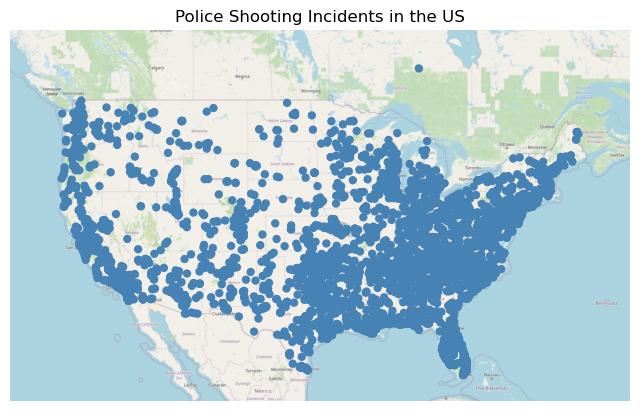

In [68]:
contiguous_usa = gpd.read_file(gplt.datasets.get_path("contiguous_usa"))
ax = gplt.webmap(contiguous_usa, projection = gplt.crs.WebMercator())
gplt.pointplot(df_geo, ax = ax)
plt.title("Police Shooting Incidents in the US")
plt.show()

In [103]:
# add state code to contiguous_usa
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}
contiguous_usa['state_code'] = contiguous_usa['state'].map(us_state_to_abbrev)

In [119]:
# add incidents to contiguous_usa
contiguous_usa['incidents'] = contiguous_usa['state_code'].map(df_geo['state'].value_counts())
contiguous_usa = contiguous_usa.sort_values(by = 'incidents', ascending = False)
contiguous_usa.head(10)

,state,adm1_code,population,geometry,state_code,incidents
6,California,USA-3521,37253956,"POLYGON ((-114.35490 34.46467, -114.16597 34.2...",CA,1019
21,Texas,USA-3536,25145561,"POLYGON ((-93.57824 31.21613, -93.48984 31.079...",TX,638
28,Florida,USA-3542,18801310,"POLYGON ((-80.05654 26.88000, -80.08801 26.205...",FL,455
5,Arizona,USA-3520,6392017,"POLYGON ((-109.04523 36.99991, -109.04367 31.3...",AZ,311
29,Georgia,USA-3543,9687653,"POLYGON ((-80.86501 32.03316, -81.33629 31.440...",GA,258
7,Colorado,USA-3522,5029196,"POLYGON ((-102.05017 40.00082, -102.04012 38.4...",CO,254
35,North Carolina,USA-3549,9535483,"POLYGON ((-75.86808 36.55118, -75.72731 35.550...",NC,200
18,Oklahoma,USA-3533,3751351,"POLYGON ((-94.62861 36.54059, -94.43017 35.483...",OK,196
4,Washington,USA-3519,6724540,"POLYGON ((-116.99807 46.33017, -116.90653 46.1...",WA,195
36,Ohio,USA-3550,11536504,"POLYGON ((-82.21066 38.57948, -82.34083 38.440...",OH,194


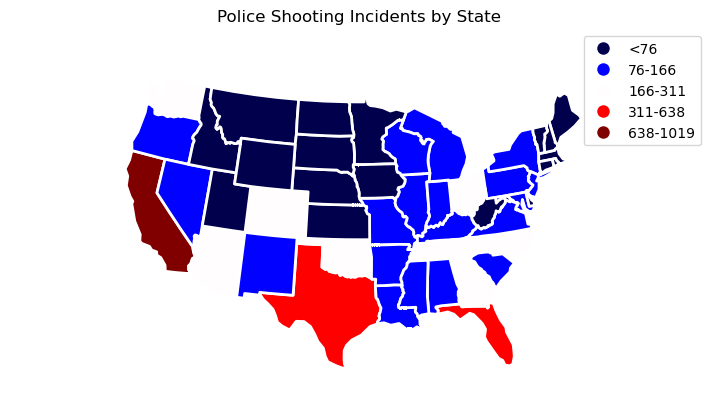

In [145]:
# plot incidents by state
gplt.choropleth(
    contiguous_usa,
    hue = 'incidents',
    projection = gplt.crs.AlbersEqualArea(),
    edgecolor = 'white',
    linewidth = 2,
    cmap = 'seismic',
    legend = True,
    scheme = "FisherJenks",
    legend_labels = [
        "<76",
        "76-166",
        "166-311",
        "311-638",
        "638-1019",
    ],
    figsize = (9, 5)
)
plt.title("Police Shooting Incidents by State")
plt.show()